In [1]:
import pandas as pd
import numpy as np
import cv2
from keras.preprocessing import image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.optimizers import Adam

Using TensorFlow backend.


# EDA
Download arrays from data/npy_files that were created in '1. preprocessing'

In [2]:
images = np.load("data/npy_files/images_arrays.npy")
labels = np.load("data/npy_files/labels.npy")
multi_labels = np.load("data/npy_files/multi_labels.npy")

In [3]:
df_labels = pd.read_csv('data/trainLabels_cropped.csv')
images_names = sorted(df_labels.image.values) 

In [4]:
# imbalance. mb we should do smt, je ne sa pas
df_labels.level.value_counts()

0    25802
2     5288
1     2438
3      872
4      708
Name: level, dtype: int64

In [5]:
def show_image(img):
    #b,g,r = cv2.split(opencv_image)
    #rgb_image = cv2.merge([r,g,b])
    #img = cv2.imread(array)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

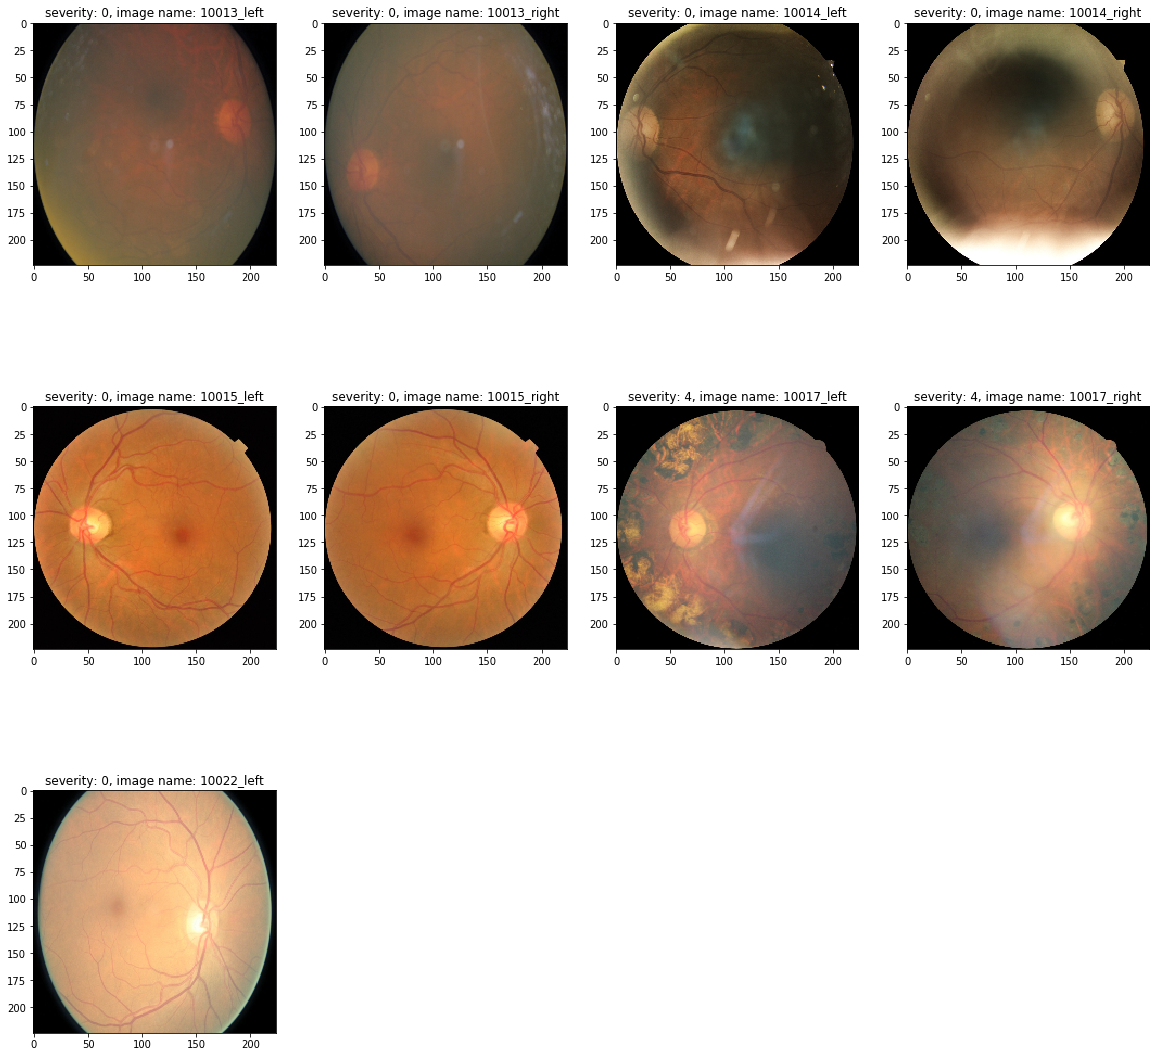

In [6]:
plt.figure(figsize=(20,20)),
for i in range(10, 19):
    plt.subplot(330 + 1 + i)
    show_image(images[i])   
    plt.title("severity: " + str(labels[i]) + ", image name: " + images_names[i])

### split on 60/20/20 - train/test/val

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
     images, multi_labels, test_size=0.33, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(
    images, multi_labels, test_size=0.4, random_state=42)

x_test, x_val, y_test, y_val = train_test_split(
    x_test, y_test, test_size=0.5, random_state=42)

In [8]:
n = len(labels)
print("train shape ", x_train.shape)
print("train labels shape ", y_train.shape)
print("percentage of all {} pictures: ".format(n), round(x_train.shape[0]/n, 2)*100, "% \n")

print("validation shape ", x_val.shape)
print("validation labels shape ", y_val.shape)
print("percentage of all {} pictures: ".format(n), round(x_val.shape[0]/n, 2)*100, "% \n")

print("test shape ", x_test.shape)
print("test labels shape ", y_test.shape)
print("percentage of all {} pictures: ".format(n), round(x_test.shape[0]/n, 2)*100, "%")

train shape  (600, 224, 224, 3)
train labels shape  (600, 5)
percentage of all 1000 pictures:  60.0 % 

validation shape  (200, 224, 224, 3)
validation labels shape  (200, 5)
percentage of all 1000 pictures:  20.0 % 

test shape  (200, 224, 224, 3)
test labels shape  (200, 5)
percentage of all 1000 pictures:  20.0 %


### !enlarge the dataset with horizontal and vertical flips.

In [14]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        #zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        #fill_mode='constant',
        #cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)

### Create a callback for Kappa score. 
some errors stalus9, potim shota treba pominiatu

In [15]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

# Building and training part

In [16]:
def build_model(transfer_learning_model):
    """
    transfer_learning_model - some pretrained architecture
    """
    model = Sequential()
    model.add(transfer_learning_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def run_model(model, metric_type):
    history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(x_val, y_val)#,
    #callbacks=[metric_type]
)

In [17]:
kappa_metrics = Metrics()
mse_metrics =  "MSE()"

# DenseNet-121

In [18]:
# using DenseNet-121
densenet = DenseNet121(
    weights='data/densenet_weights/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

model_densenet = build_model(densenet)
model_densenet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
run_model(model_densenet, kappa_metrics)

Epoch 1/15


# Some other model

In [ ]:
# build model

In [ ]:
# run model